In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import MetaTrader5 as mt5
import datetime as dt
import ta
import pytz
timezone = pytz.timezone("Etc/UTC")
timezone
today = dt.datetime.now()

c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def padrao(df):
    df.rename(columns={'time':'Date', 'open':'Open', 'high':'High','low':'Low','close':'Close'}, inplace=True)
    df.drop(['tick_volume','spread','real_volume'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    return df

def retorno(df):
    df['Retorno'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)
    return df

In [3]:
def var(df):
    

 

    


    df['RSL5'] = (df['Close']/df['Close'].rolling(5).mean())-1
    df['RSL5q'] = pd.qcut(df['RSL5'], q=7, labels=False)
    df['RSL20'] = (df['Close']/df['Close'].rolling(20).mean())-1

    df['delta'] = df['Close'].diff()
    df['delta_cat'] = pd.qcut(df['delta'], 20, labels=False)
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_cat'] = pd.qcut(df['rsi'], 7,labels=False)

    df['filtro'] = np.where(df["RSL5"] < df["RSL20"], 1, -1) 
    df['media_movel'] = df['Close'].rolling(200).mean()
    df['media_movel2'] = df['Close'].rolling(5).mean()
    h = df['media_movel2'] / df['media_movel']
    l = 3 
    df['tan200'] = h/l
    df['tan200_cat'] = pd.qcut(df['tan200'], q=20, labels=False)
    df['ang200'] = np.degrees(df['tan200'])
    df['ang200_cat'] = pd.qcut(df['ang200'], q=20, labels=False)
    df['ang_cat'] = pd.qcut(df['ang200'], q=5, labels=False)

    df['sinal'] = np.where((df['filtro']==-1)& ((df['ang_cat'] ==1) | df['ang_cat'] ==2), -1,
                            np.where((df['filtro']==1)& ((df['ang_cat'] ==0) | df['ang_cat'] ==4), 1, 0)) 

    df['rsi_sinal'] = np.where(df['rsi'] < 30, 1,
                          np.where(df['rsi'] > 70, -1, 0))


    df['rsi_cat_sinal'] = np.where((df['rsi_sinal'] == 1) & ((df['rsi_cat'] == 0)| (df['rsi_cat'] == 6)),1,
                        np.where((df['rsi_sinal'] == -1) & ((df['rsi_cat'] == 3)| (df['rsi_cat'] == 5)), -1, 0))

    df['desvio_padrao'] = df["Retorno"].rolling(window=15).std()
    df['media'] = df["Retorno"].rolling(window=15).mean()
    df['ajuste_media'] = df["Retorno"] - df['media']
    df['max_diff'] = df['ajuste_media'].rolling(window=15).max()
    df['max_diff_cat'] = pd.qcut(df['max_diff'], 20, labels=False)
    df['min_diff'] = df['ajuste_media'].rolling(window=15).min()
    df['min_diff_cat'] = pd.qcut(df['min_diff'], 20, labels=False)
    df['R/S'] = (df['max_diff'] - df['min_diff'])/df['desvio_padrao']
    df['R/S_cat'] = pd.qcut(df['R/S'], 20, labels=False)
    df['hurst'] = (np.log2(df['R/S'].values))/np.log2(15)
    df['hurst_cat'] = pd.qcut(df['hurst'], 20, labels=False)

    df['hurst_sinal'] = np.where(df['hurst'] > 0.5, 1, np.where(df['hurst'] < 0.45, -1, 0))

    df['std15'] = df['Close'].rolling(15).std()
    df['MA'] = df['Close'].rolling(5).mean()

    df["zscore"] = ((df["Close"]-df['Close'].rolling(5).mean())/df['Close'].rolling(10).std())
    std = (df['zscore'].std())*1.2
    df['zscore_sinal'] = np.where(df['zscore'] > std, -1, np.where(df['zscore'] < -std, 1, 0))


    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    #df['rsi'] = pd.qcut(df['rsi'], 5,labels=False)





    stochasticOscillator = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=15, smooth_window=3)
    df['stochasticOscillator'] = stochasticOscillator.stoch()
    df['stochasticOscillator'] = df['stochasticOscillator']/100
    #df['stochasticOscillator'] = pd.qcut(df['stochasticOscillator'], 5, labels=False)

    df['stochasticOscillator_sinal'] = np.where(df['stochasticOscillator'] <= 0.2, 1, np.where(df['stochasticOscillator'] < 0.8, -1, 0))



    #bandas de bollingerBand
    bollingerBand = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_bollinger_avg'] = bollingerBand.bollinger_mavg()
    df['bb_lband'] = bollingerBand.bollinger_lband()
    df['bb_hband'] = bollingerBand.bollinger_hband()
    df['bb_hband_cat'] = pd.qcut(df['bb_hband'], 10, labels=False)
    df['sinal_bb'] = np.where(df['Close']>df['bb_hband'],-1, np.where(df['Close']<df['bb_lband'],1,0))


    
    h = df['Close'].shift(21) - df['Close']
    l = 21
    df['tan30'] = h/l
    df['ang30'] = np.arctan(df['tan30'])
    std = (df['ang30'].std())
    df['tan30_sinal'] = np.where(df['ang30'] > std, 1, np.where(df['ang30'] < -std, -1, 0))
    df['tan30_cat'] = pd.qcut(df['ang30'], q=4, labels=[1,2,3,4])




    stochRSI = ta.momentum.StochRSIIndicator(close=df['Close'], window=15, smooth1=3, smooth2=3)
    df['stochRSI'] = stochRSI.stochrsi()
    df['stochRSI_cat'] = pd.qcut(df['stochRSI'], 5, labels=False)

    df['stochRSI_sinal'] = np.where((df['tan30_cat'] == 2) & (df['stochRSI_cat'] == 2), 1,
                                np.where((df['tan30_cat'] == 3) & ((df['stochRSI_cat'] == 4) |(df['stochRSI_cat'] == 4)), -1, 0))



    vol_p1 = 20
    df['Vol'] = np.round(df['Retorno'].rolling(vol_p1).std()*np.sqrt(252), 4)

    df["Date"] = df.index
    df["WeekDay"] = df["Date"].dt.dayofweek #Monday is day 0


    WeeklyVol = df["Vol"]/np.sqrt(52)
    RefPrice = df["Close"]
    df["WeeklyVol"] = df["Vol"]/np.sqrt(52)
    df["RefPrice"] = df["Close"]

    for i in range(1,len(df)):
        if df["WeekDay"][i] == 0:
            df["WeeklyVol"][i] = WeeklyVol[i-1]
            df["RefPrice"][i] = RefPrice[i-1]
        else:
            df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
            df["RefPrice"][i] = df["RefPrice"][i-1]

    df["Supply_Band_1d"] = np.round(df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_1d"] = np.round(df["RefPrice"] - df["WeeklyVol"]*df["RefPrice"], 2)
    df["Supply_Band_2d"] = np.round(2*df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_2d"] = np.round(df["RefPrice"] - 2*df["WeeklyVol"]*df["RefPrice"], 2)


    df['macd_9'] = df['Retorno'].rolling(window=10).mean()
    df['macd_9_cat'] = pd.qcut(df['macd_9'], 10, labels=False)
    df['macd_26'] = df['Retorno'].ewm(span=30, adjust=False).mean()
    df['disc_macs'] = (df['macd_9'] - df['macd_26'])-1
    df['disc_macs'] = pd.qcut(df['disc_macs'], 10, labels=False)

    df["dis_vol"] = df["Vol"]/df["WeeklyVol"]
    df["dis_vol_cat"] = pd.qcut(df["dis_vol"], 7, labels=False)

    df['Return20'] = df['Close'].pct_change(20)
    df['sum_returns']=df['Return20'].rolling(5).mean()
    df['return_cost'] = df['Return20']/df['sum_returns']
    df['return_cost_cat'] = pd.qcut(df['return_cost'], 7, labels=False)


    df['MA20'] = df['Close'].rolling(20).mean()
    #df['Return20'] = df['Return20'].shift(-20)
    df['STD_Returns'] = df['Return20'].rolling(20).std()
    df['RSL20'] = (df['Close']/df['MA20'])-1
    df['RSL'] = (df['Close']/df['Close'].rolling(10).mean())-1

    df['delta1'] = df['Close'].diff()
    df['delta1_cat'] = pd.qcut(df['delta1'], 20, labels=False)
    df['gain1'] = np.where(df['delta1']>=0, df['delta1'], 0)
    df['loss1'] = np.where(df['delta1']<0, abs(df['delta1']), 0)
    avg_gain1 = df['gain1'].rolling(window=20).mean()
    avg_loss1 = df['loss1'].rolling(window=20).mean()
    rs1 = avg_gain1 / avg_loss1
    df['rsi1'] = 100 - (100 / (1 + rs1))




    last_friday_return = 0

    df["FRI_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_friday_return = row["Return20"]
        
        df.at[idx, "FRI_Returns"] = last_friday_return

    # Initialize a variable to store the last Friday STD_Returns
    last_STD_Returns = 0

    # Create a new column for the Friday STD_Returns in df1
    df["FRI_STD_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_STD_Returns = row["STD_Returns"]
        
        df.at[idx, "FRI_STD_Returns"] = last_STD_Returns


    # Initialize a variable to store the last Friday RSL
    last_RSL = 0

    # Create a new column for the Friday RSL in df1
    df["FRI_RSL"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_RSL = row["RSL20"]
        
        df.at[idx, "FRI_RSL"] = last_RSL

    last_rsi = 0
    df['FRI_rsi'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_friday_rsi = row['rsi1']

        df.at[idx, "FRI_rsi"] = last_rsi

    df.dropna(axis = 0, inplace = True) 
    #Distância do cosseno
    # Initialize a list to store the results for each row
    COS_DIST = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST"] = COS_DIST
    df['COS_DIST_cat'] = pd.qcut(df['COS_DIST'], 7, labels=False)


    # Iterate over each row in the DataFrame

    COS_DIST2 = []
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST2.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST2"] = COS_DIST2
    df['COS_DIST2_cat'] = pd.qcut(df['COS_DIST2'], 7, labels=False)





    # Initialize a list to store the Euclidean distances for each row
    euclidean_distances = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST"] = euclidean_distances
    df['EUC_DIST_cat'] = pd.qcut(df['EUC_DIST'], 7, labels=False)

    euclidean_distances2 = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances2.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST2"] = euclidean_distances2
    df['EUC_DIST2_cat'] = pd.qcut(df['EUC_DIST2'], 7, labels=False)


    df['curva_rsl'] = np.where(df['FRI_RSL'] == df['RSL20'], 0, 
                            np.where(df['FRI_RSL'] > df['RSL20'], 1, -1))

    df['curva_std'] = np.where(df['FRI_STD_Returns'] == df['STD_Returns'], 0, 
                            np.where(df['FRI_STD_Returns'] > df['STD_Returns'], 1, -1))


    df['dis_rsl'] = df['RSL20']/df['FRI_RSL']

    df['dis_std'] = df['STD_Returns']/df['FRI_STD_Returns']


    df['dis_euc_sinal'] = np.where(((df['EUC_DIST2_cat']== 1) & (df['EUC_DIST_cat']== 6)), 1,
                                np.where(((df['EUC_DIST_cat']== 2) | (df['EUC_DIST_cat']== 0)) & ((df['EUC_DIST2_cat']== 0) | (df['EUC_DIST2_cat']== 2)), -1, 0))

    df['dis_cos_sinal'] = np.where(((df['COS_DIST_cat']== 5) | (df['COS_DIST_cat']== 1)) & (df['COS_DIST2_cat']== 3), 1,
                                np.where(((df['COS_DIST_cat']== 0) | (df['COS_DIST_cat']== 4)) & ((df['COS_DIST2_cat']== 2) | (df['COS_DIST2_cat']== 0)), -1, 0))

    df['RSL20_cat'] = pd.qcut(df['RSL20'], 7, labels=False)
    return df


In [4]:
import pickle
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def rede(df):
    var = ['RSL5', 'RSL5q', 'RSL20','RSL20_cat', 'delta', 'gain', 'loss', 'rsi', 'rsi_cat', 'filtro', 'media_movel',
       'media_movel2', 'tan200', 'ang200', 'ang_cat', 'sinal', 'rsi_sinal', 'rsi_cat_sinal', 'desvio_padrao',
       'media', 'ajuste_media', 'max_diff', 'min_diff', 'R/S', 'hurst', 'hurst_sinal', 'std15', 'MA', 'zscore',
       'zscore_sinal', 'stochasticOscillator', 'stochasticOscillator_sinal', 'bb_bollinger_avg', 'bb_lband',
       'bb_hband', 'sinal_bb', 'tan30', 'ang30', 'tan30_sinal', 'tan30_cat', 'stochRSI', 'stochRSI_cat',
       'stochRSI_sinal', 'Vol', 'WeeklyVol', 'RefPrice', 'Supply_Band_1d', 'Demand_Band_1d', 'Supply_Band_2d',
       'Demand_Band_2d', 'macd_9', 'macd_26', 'disc_macs', 'dis_vol', 'dis_vol_cat', 'Return20', 'sum_returns',
       'return_cost', 'return_cost_cat', 'MA20', 'STD_Returns', 'RSL', 'delta1', 'gain1', 'loss1', 'rsi1',
       'FRI_Returns', 'FRI_STD_Returns', 'FRI_RSL', 'FRI_rsi', 'COS_DIST', 'COS_DIST_cat', 'COS_DIST2',
       'COS_DIST2_cat', 'EUC_DIST', 'EUC_DIST_cat', 'EUC_DIST2', 'EUC_DIST2_cat', 'curva_rsl', 'curva_std',
       'dis_rsl', 'dis_std', 'dis_euc_sinal', 'dis_cos_sinal']



    x_train = df[var]

    # Definindo o número de clusters/bins
    n_bins = 20

    # Usando K-means para criar os clusters
    kmeans = KMeans(n_clusters = n_bins, random_state = 42).fit(x_train)
    df['cluster'] = kmeans.labels_


    lista = ['tan200_cat','ang200_cat','sinal','rsi_cat_sinal','hurst','zscore_sinal','stochasticOscillator_sinal','tan30_cat',
    'stochRSI_sinal','disc_macs','dis_vol_cat','COS_DIST_cat','COS_DIST2_cat','EUC_DIST','curva_std','dis_euc_sinal',
    'dis_cos_sinal']

    filename = 'modelo_mlp1_xau.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    df['rede'] = loaded_model.predict(df[lista])
    return df

In [5]:
ativos = ['XAUUSD']
ativo = ativos[0]
mt5.initialize()

g = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, today, 700)
g = pd.DataFrame(g)
g['time'] = pd.to_datetime(g['time'], unit='s')
padrao(g)
retorno(g)




,Open,High,Low,Close,Retorno
Date,,,,,
2021-08-20,1779.00,1788.39,1778.41,1780.96,0.000489
2021-08-23,1779.90,1806.42,1776.47,1805.42,0.013734
2021-08-24,1805.21,1809.56,1800.71,1802.83,-0.001435
2021-08-25,1802.62,1803.03,1782.56,1790.25,-0.006978
2021-08-26,1790.33,1798.20,1780.11,1791.77,0.000849
...,...,...,...,...,...
2024-04-30,2334.61,2336.27,2285.09,2285.25,-0.021641
2024-05-01,2286.58,2328.23,2281.63,2317.16,0.013963
2024-05-02,2317.05,2326.40,2285.46,2303.36,-0.005956


In [6]:
var(g)

C:\Users\camps pro\AppData\Local\Temp\ipykernel_27076\798830609.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["WeekDay"][i] == 0:
C:\Users\camps pro\AppData\Local\Temp\ipykernel_27076\798830609.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["WeeklyVol"][i] = WeeklyVol[i-1]
C:\Users\camps pro\AppData\Local\Temp\ipykernel_27076\798830609.py:132: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) thi

,Open,High,Low,Close,Retorno,RSL5,RSL5q,RSL20,delta,delta_cat,...,EUC_DIST_cat,EUC_DIST2,EUC_DIST2_cat,curva_rsl,curva_std,dis_rsl,dis_std,dis_euc_sinal,dis_cos_sinal,RSL20_cat
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-30,1852.69,1863.92,1848.29,1854.45,0.000858,-0.000553,3.0,0.003452,1.59,10.0,...,3,48.131496,2,-1,-1,1.458885,1.06922,0,0,3
2022-05-31,1855.81,1857.07,1835.10,1837.59,-0.009092,-0.006585,1.0,-0.004844,-16.86,2.0,...,1,43.426910,1,1,-1,-2.047434,1.097366,0,0,2
2022-06-01,1836.84,1849.99,1828.47,1846.53,0.004865,-0.001033,3.0,0.000939,8.94,14.0,...,1,42.439152,1,1,-1,0.396699,1.104642,0,0,3
2022-06-02,1844.71,1870.38,1844.10,1868.25,0.011763,0.008809,5.0,0.012952,21.72,18.0,...,3,48.233584,2,-1,-1,5.474201,1.153933,0,0,4
2022-06-03,1867.36,1874.06,1847.35,1850.93,-0.009271,-0.000335,3.0,0.004420,-17.32,2.0,...,0,43.911952,1,0,0,1.0,1.0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2334.61,2336.27,2285.09,2285.25,-0.021641,-0.015520,0.0,-0.023588,-50.55,0.0,...,6,50.599341,3,1,-1,-31.007336,1.676991,0,0,0
2024-05-01,2286.58,2328.23,2281.63,2317.16,0.013963,-0.001892,2.0,-0.010320,31.91,19.0,...,6,52.000017,3,1,-1,-13.565836,1.964332,0,0,1
2024-05-02,2317.05,2326.40,2285.46,2303.36,-0.005956,-0.005397,1.0,-0.016482,-13.80,3.0,...,6,51.456620,3,1,-1,-21.665643,2.208703,0,0,1


c:\Users\camps pro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\camps pro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


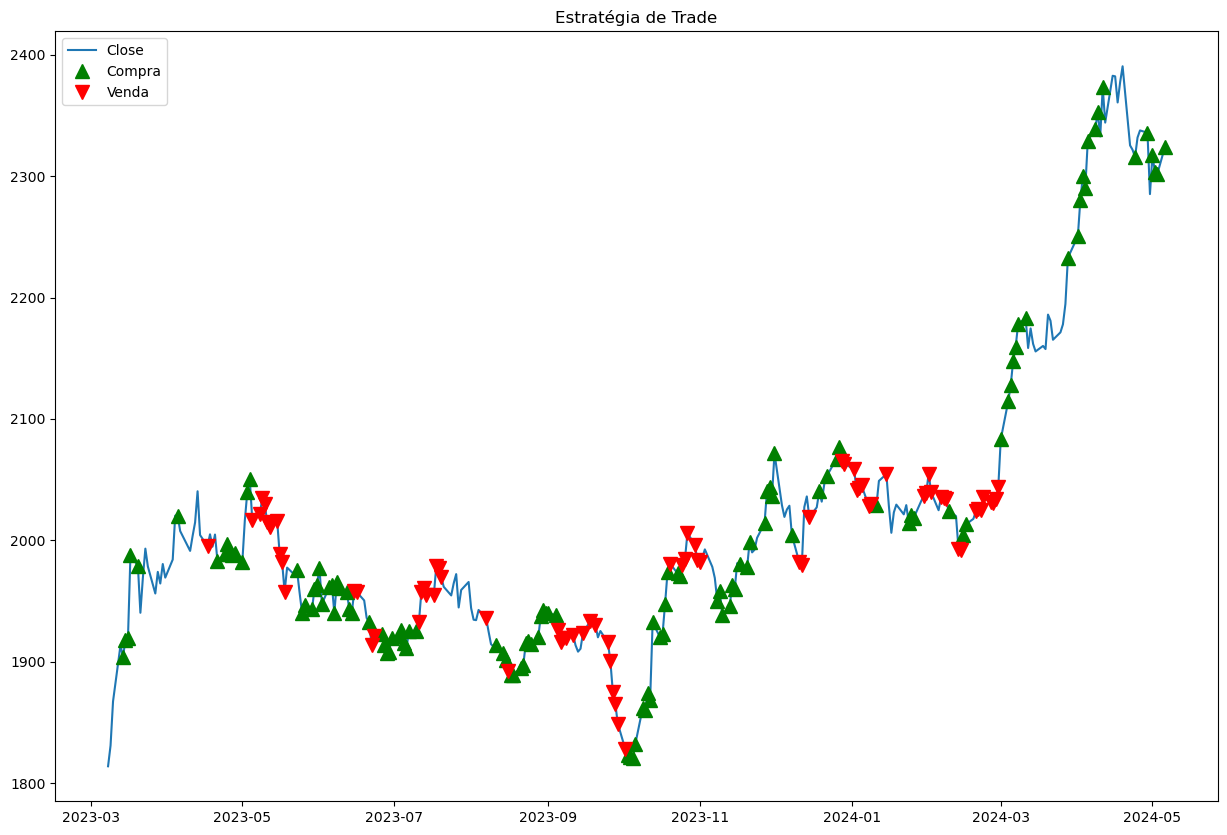

C:\Users\camps pro\AppData\Local\Temp\ipykernel_27076\369082171.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g["Retorno10"] = g["Close"].pct_change(3)*100
C:\Users\camps pro\AppData\Local\Temp\ipykernel_27076\369082171.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g["Alvo10"] = g["Retorno10"].shift(-3)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_27076\369082171.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

retorno 132.83695201175567
acerto 204
erro 129
acuracia 0.6126126126126126
total de trades 333
total de dias 500
retorno acumulado em % nan
retorno medio do acerto 0.26727756944015224
retorno medio do erro -0.9151708472717199
retorno medio do acerto 1.2164141116078055
stop loss recomendado de: - 1.5987251542841758
Compre


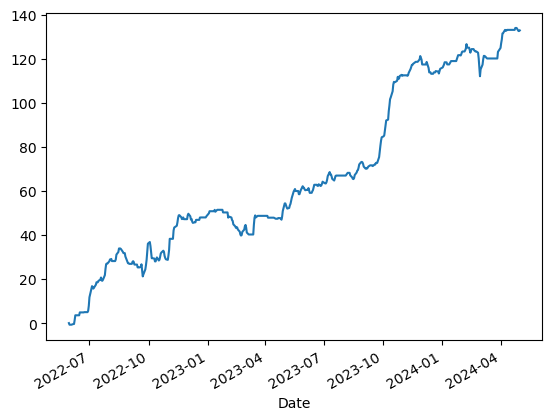

In [7]:
rede(g)



g['decisao'] = np.where((g['rede'] == 1) & ((g['rsi'] > 80) | (g['RSL20'] < 0)), 1,
                        np.where((g['rede'] == 0) & ((g['rsi'] < 20) | (g['RSL20'] > 0)), -1, 0))



#plotar um grafico das posicoes
plt.figure(figsize=(15,10))
plt.plot(g['Close'].iloc[-300:], label='Close')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == 1].iloc[-300:], '^', markersize=10, color='g', lw=0, label='Compra')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == -1].iloc[-300:], 'v', markersize=10, color='r', lw=0, label='Venda')
plt.title('Estratégia de Trade')
plt.legend()
#sublinhar o que é compra e o que é venda por um periodo de 3 dias apos o sinal

plt.show()
g["Retorno10"] = g["Close"].pct_change(3)*100
g["Alvo10"] = g["Retorno10"].shift(-3)
g['alvo_bin'] = np.where(g['Alvo10'] > 0, 1, 0)   
g['retorno'] = np.where(g['decisao'] == 1, g['Alvo10'], np.where(g['decisao'] == -1, -g['Alvo10'], 0))
#meta['retorno'] = np.where(meta['retorno'] <= -1, -1, meta['retorno'])
g['retorno_acumulado'] = g['retorno'].cumsum()
g['retorno_acumulado'].plot()

acerto = 0
erro = 0
for i in range(len(g)):
    if (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 1):
        acerto +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 0):
        acerto +=1
    elif (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 0):
        erro +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 1):
        erro +=1
print('retorno', g['retorno'].sum())
print('acerto', acerto)
print('erro', erro)
print('acuracia', acerto/(acerto+erro))
print('total de trades', acerto+erro)
print('total de dias' , len(g))
print('retorno acumulado em %', g['retorno_acumulado'][-3])
print('retorno medio do acerto',  g['retorno'].mean())
print('retorno medio do erro',  g['retorno'][g['retorno'] < 0].mean())
print('retorno medio do acerto',  g['retorno'][g['retorno'] > 0].mean())
print('stop loss recomendado de: -', g['Retorno10'].rolling(60).std().tail(1).values[0] )
if g['decisao'].iloc[-1] == 1:
    print('Compre')
elif g['decisao'].iloc[-1] == -1:
    print('Venda')
else:
    print('Fique de fora')

In [8]:
g

,Open,High,Low,Close,Retorno,RSL5,RSL5q,RSL20,delta,delta_cat,...,dis_cos_sinal,RSL20_cat,cluster,rede,decisao,Retorno10,Alvo10,alvo_bin,retorno,retorno_acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-30,1852.69,1863.92,1848.29,1854.45,0.000858,-0.000553,3.0,0.003452,1.59,10.0,...,0,3,6,1,0,NaN,0.744156,1,0.000000,0.000000
2022-05-31,1855.81,1857.07,1835.10,1837.59,-0.009092,-0.006585,1.0,-0.004844,-16.86,2.0,...,0,2,6,0,-1,NaN,0.725951,1,-0.725951,-0.725951
2022-06-01,1836.84,1849.99,1828.47,1846.53,0.004865,-0.001033,3.0,0.000939,8.94,14.0,...,0,3,6,1,0,NaN,-0.240451,0,0.000000,-0.725951
2022-06-02,1844.71,1870.38,1844.10,1868.25,0.011763,0.008809,5.0,0.012952,21.72,18.0,...,0,4,6,1,0,0.744156,-0.885320,0,0.000000,-0.725951
2022-06-03,1867.36,1874.06,1847.35,1850.93,-0.009271,-0.000335,3.0,0.004420,-17.32,2.0,...,0,3,6,1,0,0.725951,0.092386,1,0.000000,-0.725951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2334.61,2336.27,2285.09,2285.25,-0.021641,-0.015520,0.0,-0.023588,-50.55,0.0,...,0,0,9,0,0,-1.997573,0.737775,1,0.000000,132.541332
2024-05-01,2286.58,2328.23,2281.63,2317.16,0.013963,-0.001892,2.0,-0.010320,31.91,19.0,...,0,1,9,1,1,-0.879489,0.295621,1,0.295621,132.836952
2024-05-02,2317.05,2326.40,2285.46,2303.36,-0.005956,-0.005397,1.0,-0.016482,-13.80,3.0,...,0,1,9,1,1,-1.388818,NaN,0,NaN,NaN
